# Vanilla Autoencoder

_Notebook contributed to [tensorflow/examples](https://github.com/tensorflow/examples)_

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github.com/tensorflow/examples/blob/master/community/en/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/tree/master/community/en/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview
In this notebook, we will create a **vanilla autoencoder** model using the [TensorFlow subclassing API](https://www.tensorflow.org/guide/keras#model_subclassing). We are going to use the popular [MNIST dataset](http://yann.lecun.com/exdb/mnist/) (Grayscale images of hand-written digits from 0 to 9).

We deal with huge amount of data in machine learning which naturally leads to more computations. However, we can pick the parts of the data which contribute the most to a model's learning, thus leading to less computations. The process of choosing the _important_ parts of data is known as _feature selection_, which is among the number of use cases of an _autoencoder_.

But what exactly is an autoencoder? Well, let's first recall that a neural network is a computational model that is used for finding a function describing the relationship between data features $x$ and its values or labels $y$, i.e. $y = f(x)$. 

Now, an autoencoder is also a neural network. But instead of finding the function _mapping the features_ $x$ to their _corresponding values or labels_ $y$, it aims to find the function mapping the _features_ $x$ _to itself_ $x$. Wait, what? Why would we do that?

Well, what's interesting is what happens inside the autoencoder. But before we go on, let's setup our environment.

## Setup
Let's start by importing the libraries and functions that we will need.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

__version__ = '1.0.0'
__author__ = 'Abien Fred Agarap'

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
tf.random.set_seed(1)
np.random.seed(1)

print('TensorFlow version:', tf.__version__)
print('Is Executing Eagerly?', tf.executing_eagerly())

TensorFlow version: 2.0.0-beta1
Is Executing Eagerly? True


## Autoencoder model

An autoencoder consists of two components: (1) an **encoder** which learns the data representation $z$, i.e. the important features of a given data $x$ (I like to describe it as _what makes something something_), and (2) a **decoder** which reconstructs the data $\hat{x}$ based on its idea $z$ of how it is structured.
$$ z = f\big(h_{e}(x)\big)$$
$$ \hat{x} = f\big(h_{d}(z)\big)$$
where $z$ is the learned data representation by encoder $h_{e}$, and $\hat{x}$ is the reconstructed data by decoder $h_{d}$ based on $z$.

Let's further dissect the model below.

### Define an encoder layer

The first component, the **encoder**, is similar to a conventional feed-forward network. However, it is not tasked on predicting values (a _regression_ task) or categories (a _classification_ task). Instead, it is tasked to learn how the data is structured, i.e. data representation $z$. We can implement the encoder layer as follows,

In [2]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim=128, code_dim=64):
        super(Encoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=code_dim, activation=tf.nn.relu)
    
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return self.output_layer(activation)

The _encoding_ is done by passing data input $x$ to the encoder's hidden layer $h$ in order to learn the data representation $z = f(h(x))$.

We first create an `Encoder` class that inherits the [`tf.keras.layers.Layer`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer) class to define it as a layer. So, why a layer instead of a model? Recall that the encoder is a _component_ of the autoencoder model.

Analyzing the code, the `Encoder` layer is defined to have a single hidden layer of neurons (`self.hidden_layer`) to learn the input features. Then, we connect the hidden layer to a layer (`self.output_layer`) that encodes the learned activations to lower dimension which consists of what it thinks as important features. Hence, the "output" of the `Encoder` layer is the _what makes something something_ $z$ of the data $x$.

### Define a decoder layer

The second component, the **decoder**, is also similar to a feed-forward network. However, instead of reducing data to lower dimension, it attempts to reverse the process, i.e. reconstruct the data $\hat{x}$ from its lower dimension representation $z$ to its original dimension.

The _decoding_ is done by passing the lower dimension representation $z$ to the decoder's hidden layer $h$ in order to reconstruct the data to its original dimension $\hat{x} = f(h(z))$. We can implement the decoder layer as follows,

In [3]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, original_dim, code_dim=64):
        super(Decoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=code_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.relu)
  
    def call(self, code):
        activation = self.hidden_layer(code)
        return self.output_layer(activation)

We now create a `Decoder` class that also inherits the `tf.keras.layers.Layer`.

The `Decoder` layer is also defined to have a single hidden layer of neurons to reconstruct the input features $\hat{x}$ from the learned representation $z$ by the encoder $f\big(h_{e}(x)\big)$. Then, we connect its hidden layer to a layer that decodes the data representation from lower dimension $z$ to its original dimension $\hat{x}$. Hence, the "output" of the `Decoder` layer is the reconstructed data $\hat{x}$ from the data representation $z$.

Ultimately, the output of the decoder is the autoencoder's output.

Now that we have defined the components of our autoencoder, we can finally build our model.

### Build the autoencoder model

We can now build the autoencoder model by instantiating `Encoder` and `Decoder` layers.

In [4]:
class Autoencoder(tf.keras.Model):
    def __init__(self, intermediate_dim, code_dim, original_dim):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(intermediate_dim=intermediate_dim, code_dim=code_dim)
        self.decoder = Decoder(code_dim=code_dim, original_dim=original_dim)

    def call(self, input_features):
        code = self.encoder(input_features)
        reconstructed = self.decoder(code)
        return reconstructed

As discussed above, the encoder's output is the input to the decoder, as it is written above (`reconstructed = self.decoder(code)`).

## Reconstruction error

We only discussed and built the model, but we talked about how it actually learns. All we know up to this point is the _flow of learning_ from the input layer of the encoder which supposedly learns the data representation, and use that representation as input to the decoder that reconstructs the original data.
Like "simple" neural networks, an autoencoder learns through [backpropagation](https://www.youtube.com/watch?v=LOc_y67AzCA). However, instead of comparing the values or labels of the model, we compare the reconstructed data and the original data. Let's call this comparison the reconstruction error function, and it is given by the following equation,
$$ L = \dfrac{1}{n} \sum_{i=0}^{n-1} \big(\hat{x}_{i} - x_{i}\big)^{2}$$
where $\hat{x}$ is the reconstructed data while $x$ is the original data.

In [5]:
def loss(reconstructed, original):
    return tf.reduce_mean(tf.square(tf.subtract(reconstructed, original)))

## Forward pass and optimization

We will write a function for computing the forward pass, and applying a chosen optimization function.

In [6]:
def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        reconstructed = model(original)
        reconstruction_error = loss(reconstructed, original)
    gradients = tape.gradient(reconstruction_error, model.trainable_variables)
    gradient_variables = zip(gradients, model.trainable_variables)
    opt.apply_gradients(gradient_variables)
    
    return reconstruction_error

## The training loop

Finally, we will write a function to run the training loop. This function will take arguments for the model, the optimization function, the loss, the dataset, and the training epochs.

The training loop itself uses a `GradientTape` context defined in `train` for each batch.

In [7]:
def train_loop(model, opt, loss, dataset, epochs):
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_features in dataset:
            loss_values = train(loss, model, opt, batch_features)
            epoch_loss += loss_values
        model.loss.append(tf.reduce_mean(epoch_loss))
        print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, tf.reduce_mean(epoch_loss)))

## Process the dataset

Now that we have defined our `Autoencoder` class, the loss function, and the training loop, let's import the dataset. We will normalize the pixel values for each example through dividing by maximum pixel value. We shall flatten the examples from 28 by 28 arrays to 784-dimensional vectors.

In [8]:
(training_features, _), (test_features, _) = mnist.load_data()

training_features = training_features / 255.

training_features = training_features.astype(np.float32)
training_features = training_features.reshape(training_features.shape[0], 784)
test_features = test_features.reshape(test_features.shape[0], 784)

training_dataset = tf.data.Dataset.from_tensor_slices(training_features)
training_dataset = training_dataset.prefetch(1024)
training_dataset = training_dataset.shuffle(1024)
training_dataset = training_dataset.batch(128)

W0803 22:41:38.194061 140408360904512 deprecation.py:323] From /home/darth/tf2/lib/python3.6/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Train the model

Now all we have to do is instantiate the autoencoder model and choose an optimization function, then pass the intermediate dimension and the original dimension of the images.

In [9]:
model = Autoencoder(intermediate_dim=128, code_dim=64, original_dim=784)
opt = tf.optimizers.Adam(learning_rate=1e-3)

train_loop(model, opt, loss, training_dataset, 10)

Epoch 1/10. Loss: 13.812748908996582
Epoch 2/10. Loss: 7.5249247550964355
Epoch 3/10. Loss: 6.640940189361572
Epoch 4/10. Loss: 6.169541358947754
Epoch 5/10. Loss: 5.860179424285889
Epoch 6/10. Loss: 5.659181118011475
Epoch 7/10. Loss: 5.526548385620117
Epoch 8/10. Loss: 5.432300567626953
Epoch 9/10. Loss: 5.363037109375
Epoch 10/10. Loss: 5.309214115142822


## Plot the in-training performance

Let's take a look at how the model performed during training in a couple of plots.

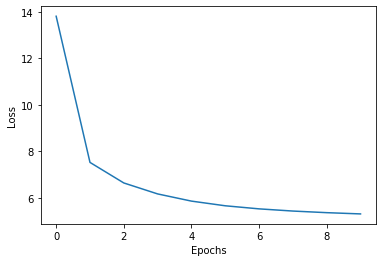

In [10]:
plt.plot(range(10), model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Predictions

Finally, we will look at some of the predictions. The wrong predictions are labeled in red color.

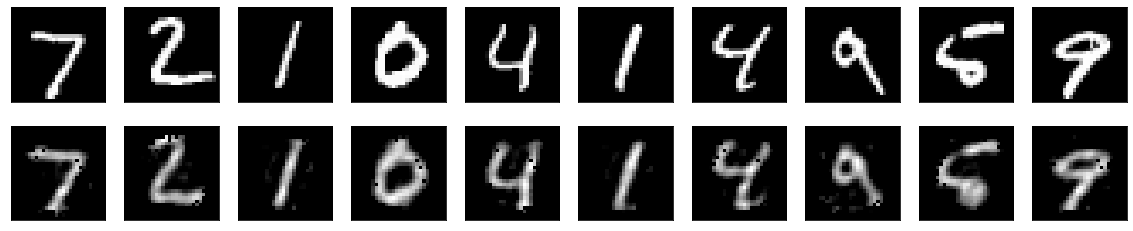

In [11]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(test_features[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(test_features)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Closing remarks

As you may see after training this model, the reconstructed images are quite blurry. A number of things could be done to move forward from this point, e.g. adding more layers, or using a convolutional neural network architecture as the basis of the autoencoder, or use a different kind of autoencoder.

## References
* Martín Abadi, Ashish Agarwal, Paul Barham, Eugene Brevdo, Zhifeng Chen, Craig Citro, Greg S. Corrado, Andy Davis, Jeffrey Dean, Matthieu Devin, Sanjay Ghemawat, Ian Goodfellow, Andrew Harp, Geoffrey Irving, Michael Isard, Rafal Jozefowicz, Yangqing Jia, Lukasz Kaiser, Manjunath Kudlur, Josh Levenberg, Dan Mané, Mike Schuster, Rajat Monga, Sherry Moore, Derek Murray, Chris Olah, Jonathon Shlens, Benoit Steiner, Ilya Sutskever, Kunal Talwar, Paul Tucker, Vincent Vanhoucke, Vijay Vasudevan, Fernanda Viégas, Oriol Vinyals, Pete Warden, Martin Wattenberg, Martin Wicke, Yuan Yu, and Xiaoqiang Zheng. TensorFlow: Large-scale machine learning on heterogeneous systems, 2015. Software available from [tensorflow.org](https://tensorflow.org/).
* Chollet, F. (2016, May 14). Building Autoencoders in Keras. Retrieved March 19, 2019, from https://blog.keras.io/building-autoencoders-in-keras.html
* Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning. MIT press.